# Examine Clusters

In [1]:
import os
from decouple import config
import second_level_functions as slf
import numpy as np
import pandas as pd
import ptitprince as pt
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf

Change task and contrast to examine clusters

In [2]:
task = 'happy'
contrast = 'interaction'

Read in images and get parameter estimates

In [3]:
base_dir = config(task)
path = os.path.join(base_dir, '2ndlevel')
copes_dir = os.path.join(base_dir, '2ndlevel', 'mixed_model')
parameter_estimates_df = slf.get_peak_voxel(base_dir, path, copes_dir, contrast)

## Plot and get mean of parameter estimates

Split parameter estimates by group and time point. Then get mean of each group and at in each time point

In [4]:
group_values = {
                'an_t1': parameter_estimates_df.loc[(parameter_estimates_df['group'] == 'AN') 
                                                      & (parameter_estimates_df['time_point'] == 't1')].iloc[:, 4:],
                'an_t2':  parameter_estimates_df.loc[(parameter_estimates_df['group'] == 'AN') 
                                                     & (parameter_estimates_df['time_point'] == 't2')].iloc[:, 4:],
                'hc_t1': parameter_estimates_df.loc[(parameter_estimates_df['group'] == 'HC') 
                                                    & (parameter_estimates_df['time_point'] == 't1')].iloc[:, 4:],
                'hc_t2': parameter_estimates_df.loc[(parameter_estimates_df['group'] == 'HC') 
                                                    & (parameter_estimates_df['time_point'] == 't2')].iloc[:, 4:]
}

In [5]:
means_std_df = pd.DataFrame(data={
    'AN T1 mean':  group_values['an_t1'].mean(),
    'AN T1 std':  group_values['an_t1'].std(),
    'HC T1 mean': group_values['hc_t1'].mean(),
    'HC T1 std': group_values['hc_t1'].std(),
    'AN T2 mean': group_values['an_t2'].mean(),
    'AN T2 std':  group_values['an_t2'].std(),
    'HC T2 mean': group_values['hc_t2'].mean(),
    'HC T2 std': group_values['hc_t2'].std(),
    'AN overall mean': pd.concat((group_values['an_t1'], group_values['an_t2'])).mean(),
    'AN overall std': pd.concat((group_values['an_t1'], group_values['an_t2'])).std(),
    'HC overall mean': pd.concat((group_values['hc_t1'], group_values['hc_t2'])).mean(),
    'HC overall std': pd.concat((group_values['hc_t1'], group_values['hc_t2'])).std(),
    'T1 overall mean': pd.concat((group_values['an_t1'], group_values['hc_t1'])).mean(),
    'T1 overall std': pd.concat((group_values['an_t1'], group_values['hc_t1'])).std(),
    'T2 overall mean': pd.concat((group_values['hc_t2'], group_values['an_t2'])).mean(),
    'T2 overall std': pd.concat((group_values['an_t2'], group_values['hc_t2'])).std()
                   }).T
means_std_df

,Frontal_Sup_2_L
AN T1 mean,1.065302
AN T1 std,0.805804
HC T1 mean,1.648148
HC T1 std,1.741508
AN T2 mean,1.543054
AN T2 std,2.385784
HC T2 mean,4.173595
HC T2 std,5.511991
AN overall mean,1.304178
AN overall std,1.789851


Plot parameter estimates

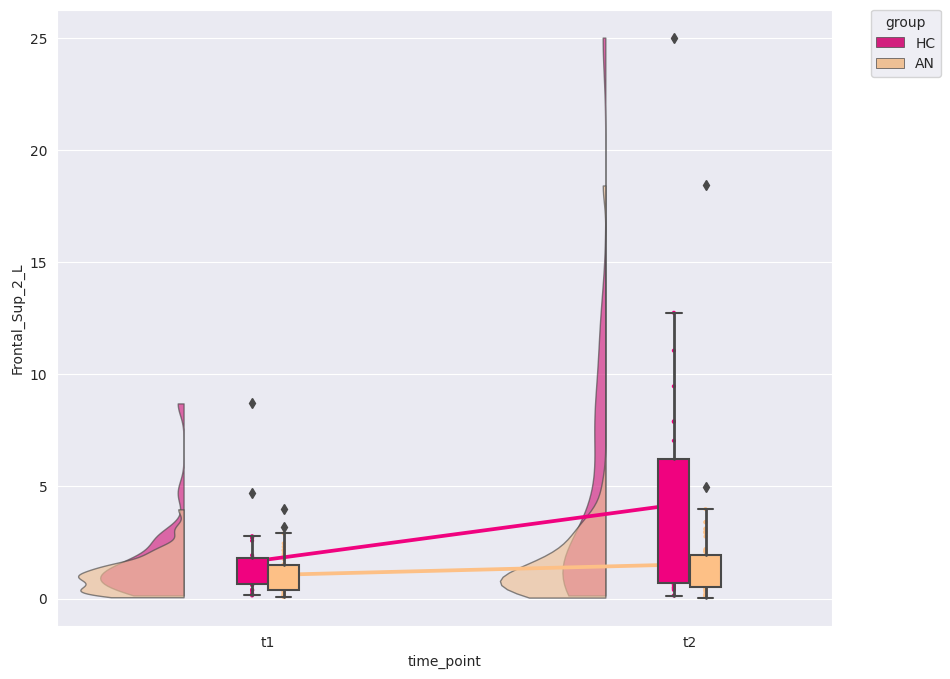

In [6]:
for cluster in means_std_df.columns:
    fig,ax = plt.subplots(1,1, figsize=(10, 8))
    pt.RainCloud(
        x="time_point", 
        y=cluster, 
        hue="group", 
        data=parameter_estimates_df, 
        palette='Accent_r', 
        alpha=.65, 
        dodge=True, 
        scale="area",
        ax=ax,
        width_viol=.5,
        jitter=0,
        pointplot = True,
        bw=.3
         )



## Linear Mixed Model

Change reference level of model by changing the name of AN to participant with AN (pAN) and HC to Control

In [7]:
regression_df = parameter_estimates_df
regression_df['group'] = regression_df['group'].apply(lambda group: 'pAN' if group == 'AN' else 'Control')

define and fit the model

In [8]:
import IPython.display as display

for cluster in means_std_df.columns:

    model = smf.mixedlm(f"{cluster} ~ time_point + group + group*time_point", 
                        regression_df, 
                        groups=regression_df["sub"]).fit()
    model.summary()
    
    summ = pd.concat((model.params.to_frame().T.rename(index={0: 'params'}), 
               model.bse_fe.to_frame().T.rename(index={0: 'std'}))).dropna(axis=1)
    print('-'*100)
    print(cluster)
    display.display(summ)

----------------------------------------------------------------------------------------------------
Frontal_Sup_2_L


,Intercept,time_point[T.t2],group[T.pAN],group[T.pAN]:time_point[T.t2]
params,1.648148,2.525447,-0.582846,-2.047695
std,0.512123,0.673816,0.609272,0.801639
